# Hierarchical Live sellers

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()

In [151]:
#importando dataset e dropando colunas vazias e sem informação útil
dataset = pd.read_csv("Live.csv").drop(columns = {'status_id','Column1','Column2','Column3','Column4'})
#transformando pra datetime
dataset['status_published'] = dataset['status_published'].astype(str).str.replace("/","-")
dataset['status_published'] = pd.to_datetime(dataset['status_published'])

In [152]:
dataset['day'] = dataset['status_published'].dt.weekday #adiciona o dia da semana
#dataset['month'] = dataset['status_published'].dt.month #adiciona o mes
dataset['hour'] = dataset['status_published'].dt.hour #adiciona a hora
dataset['minute'] = dataset['status_published'].dt.minute #adiciona os minutos

In [153]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
#transformando as labels em atributos numéricos
dataset['status_type'] = encoder.fit_transform(dataset['status_type'])

#dropando a coluna antiga, pois já adicionamos a mesma numerizada
dataset = dataset.drop(columns = {'status_published'})

In [154]:
dataset.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,day,hour,minute
0,3,529,512,262,432,92,3,1,1,0,6,6,0
1,1,150,0,0,150,0,0,0,0,0,5,22,45
2,3,227,236,57,204,21,1,1,0,0,5,6,17
3,1,111,0,0,111,0,0,0,0,0,5,2,29
4,1,213,0,0,204,9,0,0,0,0,2,3,22


In [155]:
#função para fazer o nome das colunas.
def column_name(name, df):
    result = []
    for i in range(len(df.columns)):
        result.append(name + str(i))
    return result

In [156]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
day = pd.DataFrame(ohe.fit_transform(dataset.iloc[:,10:11].values),index = dataset.index).drop(columns = {0})
day.columns = column_name("day",day)
day.shape

(7050, 6)

In [157]:
hour = pd.DataFrame(ohe.fit_transform(dataset.iloc[:,11:12].values)).drop(columns = {0})
hour.columns = column_name("hour",hour)
hour.shape

(7050, 23)

In [158]:
minute = pd.DataFrame(ohe.fit_transform(dataset.iloc[:,12:13].values)).drop(columns = {0})
minute.columns = column_name("minute",minute)
minute.shape

(7050, 59)

In [159]:
dataset = dataset.drop(columns = {'hour','day','minute'})

In [160]:
dataset = dataset.join(hour).join(day).join(minute)

In [161]:
dataset.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,...,minute49,minute50,minute51,minute52,minute53,minute54,minute55,minute56,minute57,minute58
0,3,529,512,262,432,92,3,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,150,0,0,150,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,227,236,57,204,21,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,111,0,0,111,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,213,0,0,204,9,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Faremos o PCA para ajudar na visualização dos dados e reduzin a dimensionalidade

In [162]:
from sklearn.decomposition import PCA

In [163]:
pca = PCA(n_components = 2)
X = pca.fit_transform(dataset)
explained_variance = pca.explained_variance_ratio_

In [164]:
explained_variance.sum()

0.9903888421184626

Com 2 componentes conseguimos ficar com 0.99 de variância

# Hierárquico (single linkage) 

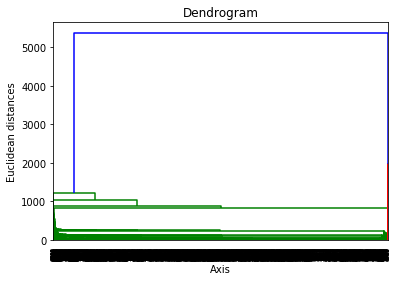

In [165]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Euclidean distances')
plt.show()

Tem-se dois clusters, visto que a maior linha vertical sem interrupções de linhas horizontais é a azul, que divide em dois clusters, o vermelho e o verde. A figura está anexada para melhor análise.

In [166]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'single')
y_hc = hc.fit_predict(X)

In [167]:
pd.Series(hc.labels_).value_counts()

1    7047
0       3
dtype: int64

De fato, mesmo tendo uma quantidade menor de instâncias no segundo cluster, se aumentassemos o número de clusters até 4 teríamos a seguinte distribuição:

In [168]:
hc_hipotesis = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'single')
y_hc_hipotesis = hc_hipotesis.fit_predict(X)
pd.Series(hc_hipotesis.labels_).value_counts()

0    7047
3       1
2       1
1       1
dtype: int64

Vamos agora plotar o resultado do nosso cluster.

In [169]:
import collections, numpy
collections.Counter(y_hc) #Número de elementos em cada cluster

Counter({1: 7047, 0: 3})

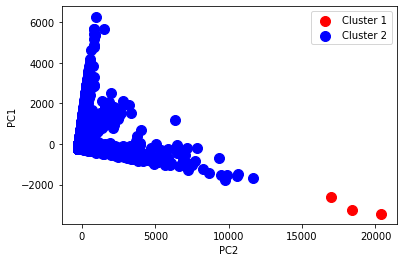

In [170]:
#plot do gráfico com clusters
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Hierárquico (complete linkage)

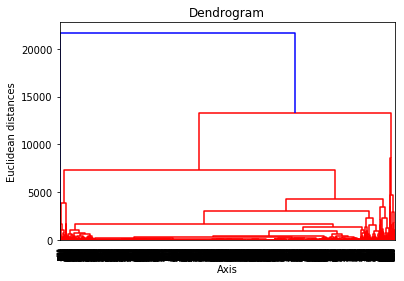

In [171]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Euclidean distances')
plt.show()

Nesse caso, devido à ao espaçamento maior no dendograma, podemos ver que a escolha entre 2 e 3 clusters torna-se a mais adequada.

In [172]:
from sklearn.cluster import AgglomerativeClustering
hc_link = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'complete')
y_hc_link = hc_link.fit_predict(X)

In [173]:
pd.Series(hc_link.labels_).value_counts()

2    6943
0     104
1       3
dtype: int64

Podemos ver que ao adicionarmos um cluster a mais, diferentemente do single linked, ele criou um novo cluster com 104 instâncias

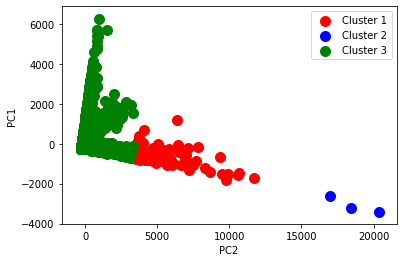

In [174]:
plt.scatter(X[y_hc_link == 0, 0], X[y_hc_link == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc_link == 1, 0], X[y_hc_link == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc_link == 2, 0], X[y_hc_link == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Normalizando os dados e tentando novamente 

In [175]:
X

array([[ 372.67032125,  308.26967385],
       [-242.58568817,  -59.78563909],
       [  11.50161025,  -11.72157772],
       ...,
       [-281.0636605 , -266.10809951],
       [-176.77788529,  216.12639311],
       [-277.08195094, -244.58476106]])

In [176]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [177]:
#limitando os valores ao intervalo -1 a 1
scaler = MinMaxScaler(feature_range=(-1,1))

In [178]:
X_scaled = scaler.fit_transform(X)

In [179]:
X_scaled

array([[-0.93672314, -0.22751206],
       [-0.99623667, -0.30333342],
       [-0.97165888, -0.29343197],
       ...,
       [-0.99995864, -0.34583694],
       [-0.9898711 , -0.24649407],
       [-0.99957349, -0.34140302]])

# Hierárquico (single linkage scaled)

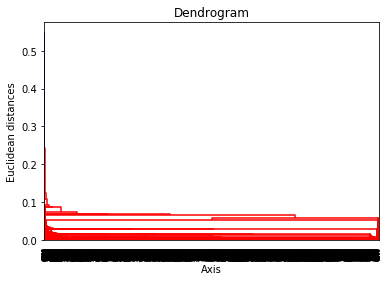

In [180]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'single'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Euclidean distances')
plt.show()

Tem-se dois clusters,ao dar um zoom na imagem fica mais perceptível 

In [181]:
from sklearn.cluster import AgglomerativeClustering
hc_single_scaled = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'single')
y_hc_single_scaled = hc_single_scaled.fit_predict(X_scaled)

In [182]:
pd.Series(hc_single_scaled.labels_).value_counts()

0    7047
1       3
dtype: int64

In [183]:
#plt.scatter(X[:,0], X[:,1], c=hc.labels_, cmap='rainbow')

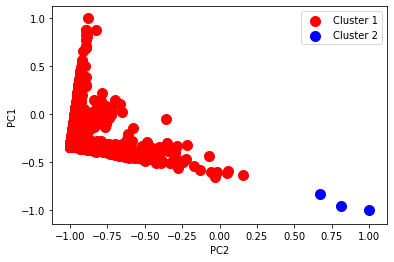

In [184]:
plt.scatter(X_scaled[y_hc_single_scaled == 0, 0], X_scaled[y_hc_single_scaled == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_scaled[y_hc_single_scaled == 1, 0], X_scaled[y_hc_single_scaled == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Hierárquico (complete linkage)

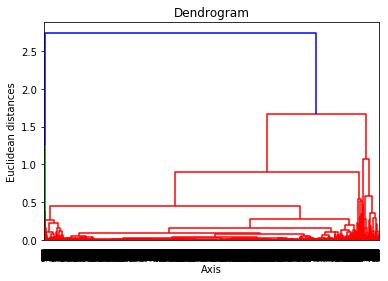

In [185]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method = 'complete'))
plt.title('Dendrogram')
plt.xlabel('Axis')
plt.ylabel('Euclidean distances')
plt.show()

É possível ter de 2 a 3 clusters de acordo com o dendograma

In [186]:
from sklearn.cluster import AgglomerativeClustering
hc_link_complete_scaled = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'complete')
y_hc_link_complete_scaled = hc_link_complete_scaled.fit_predict(X_scaled)

In [187]:
pd.Series(hc_link_complete_scaled.labels_).value_counts()

2    6694
1     344
0      12
dtype: int64

se rodarmos com 2 clusters ele junta o primeiro com o segunda e deixa o 0 que só tem 12 e se adicionarmos um a mais ele divide o de 12 em 7 e 5, o que acaba sendo, possivelmente muito específico

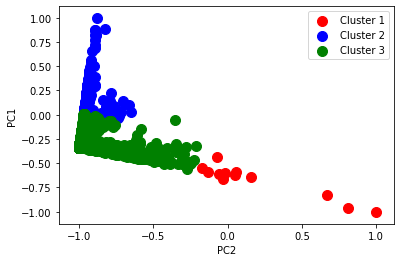

In [188]:
plt.scatter(X_scaled[y_hc_link_complete_scaled == 0, 0], X_scaled[y_hc_link_complete_scaled == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X_scaled[y_hc_link_complete_scaled == 1, 0], X_scaled[y_hc_link_complete_scaled == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X_scaled[y_hc_link_complete_scaled == 2, 0], X_scaled[y_hc_link_complete_scaled == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend()
plt.show()

# Comparando

In [189]:
#single linkage sem normalização
pd.Series(hc.labels_).value_counts()

1    7047
0       3
dtype: int64

In [190]:
#single linkage com normalização
pd.Series(hc_single_scaled.labels_).value_counts()

0    7047
1       3
dtype: int64

No single linkage houveram poucas mudanças, embora o dendograma tenha mudado, a distribuição de clusters indicada por ele permaneceu a mesma, ao passo que o número de instâncias também.

In [191]:
#complete linkage sem normalização
pd.Series(hc_link.labels_).value_counts()

2    6943
0     104
1       3
dtype: int64

In [192]:
#complete linkage com normalização
pd.Series(hc_link_complete_scaled.labels_).value_counts()

2    6694
1     344
0      12
dtype: int64

No complete linkage vemos uma mudança tanto no dendograma quanto na distribuição das instâncias nos clusters. Embora tenha permanecido o mesmo número de clusters após a normalização, os valores em cada um foram alterados